# General Imports

In [13]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
import re
import math
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.patches import Polygon, Patch
import matplotlib.image as mpimg
from matplotlib.ticker import ScalarFormatter
import matplotlib.dates as mdates

# Colors and Text Size

In [14]:
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

color = tableau20

plt.rcParams.update({'font.size': 26})

# Importing Data

In [15]:
# allFiles = glob.glob(os.path.join("..","interpolatedData","*","*.csv"))

# df = {}
# for x in allFiles:
#     name = '_'.join(x.split(os.path.sep)[1:]).split('.')[0]
#     df[name] = pd.read_csv(x,parse_dates=[0])
mergedDataFilesDp03 = glob.glob(os.path.join("..","..","mergedData","Dp03","*.csv"))
mergedDataDp03 = {(route.split("Data_")[1].split(".")[0]):pd.read_csv(route,parse_dates=[0]) for route in mergedDataFilesDp03}
mergedDataFilesPM25 = glob.glob(os.path.join("..","..","mergedData","PM25_Std","*.csv"))
mergedDataPM25 = {(route.split("Data_")[1].split(".")[0]):pd.read_csv(route,parse_dates=[0]) for route in mergedDataFilesPM25}

# Event Analysis

In [16]:
def detect_event_continuous_increase(data_frame, key):
  """
  param: data_frame: pandas DataFrame with time series index
  param: key: name of the column to parse
  return: list of lists containing the time indexes of the events for the column
  """
  # get just increaseing indexes
  growth = data_frame.mean()
  seconds = lambda x : pd.Timedelta(seconds = x)
  ten = pd.Timedelta(seconds = 10)
  one = pd.Timedelta(seconds = 1)
  slope = 1
  d_t = 20
  event_threshold = 120/d_t
  indexes = data_frame.index[d_t:]
  growth = d_t * slope

  every_10_indexes = [index for idx,(index,d) in enumerate(zip(indexes,data_frame[key][indexes[0]:indexes[-1]]))    
                        if idx % 10 == 0] # return the time index for each time index in the data frame
  increasing_indexes = [index for index,d in zip(every_10_indexes[2:],data_frame[key][every_10_indexes[2:]])
                        if d - data_frame[key][index-seconds(d_t)] > growth]  # check if the slope is over a certain rate, constant dt
  # isolate the events
  event_list = []
  if increasing_indexes:         
    temp = [increasing_indexes[0]]
    for index in increasing_indexes[1:]:
      if index-temp[-1] > seconds(d_t*event_threshold):
        event_list.append(temp)
        temp = []
      temp.append(index)
    event_list.append(temp)
  
    full_event_list = []
    for event in event_list:
      #TODO 
      pass

      
  return (increasing_indexes, event_list)


In [60]:
event_indexes, events_isolated = detect_event_continuous_increase(newdp03frame,"A8")
events_values = []
events_values.extend([newdp03frame['A8'][d] for d in events_isolated])
events_values


[Date_Time
 2022-05-09 09:53:50    31.745
 2022-05-09 09:54:00    42.765
 Name: A8, dtype: float64,
 Date_Time
 2022-05-09 10:12:30     220.353333
 2022-05-09 10:12:40     275.713333
 2022-05-09 10:12:50     397.221667
 2022-05-09 10:13:00     557.851667
 2022-05-09 10:13:10     724.533333
 2022-05-09 10:13:20     889.673333
 2022-05-09 10:13:30    1044.013333
 2022-05-09 10:13:40    1163.343333
 2022-05-09 10:13:50    1218.073333
 2022-05-09 10:14:00    1241.458333
 2022-05-09 10:14:10    1274.143333
 2022-05-09 10:14:20    1312.303333
 2022-05-09 10:14:30    1351.263333
 2022-05-09 10:14:40    1392.463333
 2022-05-09 10:14:50    1437.663333
 2022-05-09 10:15:00    1486.443333
 2022-05-09 10:15:10    1538.275000
 2022-05-09 10:15:20    1592.450000
 2022-05-09 10:15:30    1648.125000
 2022-05-09 10:15:40    1703.800000
 2022-05-09 10:15:50    1757.626667
 2022-05-09 10:16:00    1811.986667
 2022-05-09 10:16:10    1869.798333
 2022-05-09 10:16:20    1926.663333
 2022-05-09 10:16:30    1

In [62]:
pic = 0
event_matrix = {}
date_list = sorted(list(pd.Timestamp(key) for key in mergedDataPM25.keys()))
for (pm25name,pm25frame), (dp03name,dp03frame) in zip(mergedDataPM25.items(),mergedDataDp03.items()):
    pic+=1
    # creating a list of sensors for the purpose of easily assigning labels to legend of the graph
    sensors = ['A7', 'A8', 'A16']
    # sensors = ['A8']

    # take rolling average of the data frame. set the indexes of them as the time also
    newdp03frame = dp03frame.set_index("Date_Time").rolling(60*5, center = True).mean().dropna()
    dp03frame = dp03frame.set_index("Date_Time")

    newpm25frame = pm25frame.set_index("Date_Time").rolling(60*5, center = True).mean().dropna()
    pm25frame = pm25frame.set_index("Date_Time")
    
    events_times = []
    events_values = []
    for i, column in enumerate(sensors):
        try:
            event_indexes, events_isolated = detect_event_continuous_increase(newdp03frame,column) #
            events_times.extend(events_isolated)
            events_values.extend([newdp03frame[column][d] for d in events_isolated])
        except Exception as e:
            print(e,dp03name,column)
    try:
        event_matrix[dp03name] = {"Length" : pd.DataFrame([d[-1]-d[0] for d in events_times]).mean()[0].seconds}
        event_matrix[dp03name].update({"Intensity" : max([d[-1]-d[0] for d in events_times])})
    except:
        event_matrix[dp03name] = {"Length":0,"Intensity":0}
print(event_matrix)

'A7' 4-14-22 A7
'A7' 4-20-22 A7
'A8' 4-20-22 A8
'A7' 4-21-22 A7
'A7' 4-27-22 A7
'A16' 4-27-22 A16
'A8' 5-12-22 A8
'A16' 5-2-22 A16
'A16' 5-3-22 A16
'A16' 5-8-22 A16
{'05-13-22': {'Length': 198, 'Intensity': Timedelta('0 days 00:15:10')}, '05-14-22': {'Length': 140, 'Intensity': Timedelta('0 days 00:10:50')}, '05-15-22': {'Length': 82, 'Intensity': Timedelta('0 days 00:04:30')}, '05-16-22': {'Length': 86, 'Intensity': Timedelta('0 days 00:05:40')}, '05-17-22': {'Length': 126, 'Intensity': Timedelta('0 days 00:13:10')}, '05-18-22': {'Length': 134, 'Intensity': Timedelta('0 days 00:11:30')}, '05-19-22': {'Length': 234, 'Intensity': Timedelta('0 days 00:23:10')}, '05-20-22': {'Length': 72, 'Intensity': Timedelta('0 days 00:06:50')}, '05-21-22': {'Length': 251, 'Intensity': Timedelta('0 days 00:15:00')}, '05-22-22': {'Length': 168, 'Intensity': Timedelta('0 days 00:17:00')}, '05-23-22': {'Length': 269, 'Intensity': Timedelta('0 days 00:18:30')}, '05-24-22': {'Length': 217, 'Intensity': Time

In [12]:

pic = 0
date_list = sorted(list(pd.Timestamp(key) for key in mergedDataPM25.keys()))
for (pm25name,pm25frame), (dp03name,dp03frame) in zip(mergedDataPM25.items(),mergedDataDp03.items()):
    pic+=1
    # creating a list of sensors for the purpose of easily assigning labels to legend of the graph
    sensors = ['A7', 'A8', 'A16']
    # sensors = ['A8']
    # create a figure with length 36 and height 18
    fig1 = plt.figure(figsize=(30,18))
    # specify section 1 of a 2 x 1 figure
    ax1= fig1.add_subplot(2,1,1)
    # specify section 2 of a 2 x 1 figure
    ax11 = fig1.add_subplot(2,1,2)
    # add these figure objects ax1 ax11 to a list for easier access
    ax = [ax1,ax11]
    # format datetime objects to only display hour:minute
    myFmt = mdates.DateFormatter('%H:%M')
    # change the axis formatter to the one we created above
    ax[0].xaxis.set_major_formatter(myFmt)
    ax[1].xaxis.set_major_formatter(myFmt)

    # take rolling average of the data frame. set the indexes of them as the time also
    newdp03frame = dp03frame.set_index("Date_Time").rolling(60*5, center = True).mean().dropna()
    dp03frame = dp03frame.set_index("Date_Time")

    newpm25frame = pm25frame.set_index("Date_Time").rolling(60*5, center = True).mean().dropna()
    pm25frame = pm25frame.set_index("Date_Time")

    # get the maximal values of each column
    dp_max = newdp03frame.max()
    pm_max = newpm25frame.max()

    # take the max of the max column values for the sensors: this is why we use -2, to skip the vairance and average columns
    dp_max = max(dp_max[:len(dp_max)-2])
    pm_max = max(pm_max[:len(pm_max)-2])

    ylim_dp03 = 4000*math.ceil(dp_max/4000)
    ylim_pm25 = 40*math.ceil(pm_max/40)

    #check the maximal activity and change the graph colors if it exceeds a threshold
    if (dp_max > 4000) or (pm_max > 40):
        high_activity = "\nHIGH ACTIVITY"
        colorOffset = 6
    else:
        high_activity = ""
        colorOffset = 0

    events = []
    for i, column in enumerate(sensors):
        try:
            event_indexes, events_isolated= detect_event_continuous_increase(newdp03frame,column) #
            events.extend(events_isolated)
            ax[0].plot(newdp03frame.index,newdp03frame[column],color = color[i*2+colorOffset], linewidth = 5,label = f"{column}",zorder = 2)
            ax[1].plot(newpm25frame.index,newpm25frame[column],color = color[i*2+colorOffset], linewidth = 5,label = f"{column}")
            ax[0].scatter(event_indexes,newdp03frame[column][event_indexes], color = 'BLACK', marker = '^',s=100,zorder = 10)
            if events_isolated:
                max_event_length = max([len(d) for d in events_isolated])
                for event in events_isolated:
                    ax[0].fill_between([event[0],event[-1]],[0,0],[ylim_dp03,ylim_dp03],color = color[i*2+1+colorOffset],alpha = len(event)/max_event_length*.9,zorder = 1)
                
        except Exception as e:
            print(e,dp03name,column)
            ax[0].plot(newdp03frame.index,[0]*len(newdp03frame),'-',color = color[i*2+colorOffset],label = f"{column}")
            ax[1].plot(newpm25frame.index,[0]*len(newpm25frame),'-',color = color[i*2+colorOffset],label = f"{column}")
    ax[0].legend()
    ax[0].set_xlabel("Time")
    ax[0].set_ylabel('Dp>0.3 particles/0.1L')
    ax[0].set_ylim([0,ylim_dp03])
    ax[0].set(title= f"Dp>0.3 Sensor Readings 5 minute avg{high_activity}\nnumber of events:{len(events)}")
    ax[1].legend()
    ax[1].set_xlabel("Time")
    ax[1].set_ylabel('PM 2.5 microgram/cc')
    ax[1].set_ylim([0,ylim_pm25])
    ax[1].set(title= f"PM 2.5 Sensor Readings 5 minute avg")
    plt.suptitle(f"{dp03name.replace('_','-')}")
    
    imagePath = os.path.join("..","..","Graphs, Images, and Animations","Event Windows")
    if not os.path.exists(imagePath):
        os.mkdir(imagePath)
    index = date_list.index(pd.Timestamp(dp03name))
    plt.savefig(os.path.join(imagePath,f"{index:03}_activity_{dp03name}.jpg"))

    plt.close()

'A7' 4-14-22 A7
'A7' 4-20-22 A7
'A8' 4-20-22 A8
'A7' 4-21-22 A7
'A7' 4-27-22 A7
'A16' 4-27-22 A16
'A8' 5-12-22 A8
'A16' 5-2-22 A16
'A16' 5-3-22 A16
'A16' 5-8-22 A16


# Graphing all sensor data for Dp>0.3 and PM2.5

In [ ]:
pic = 0
for (pm25name,pm25frame), (dp03name,dp03frame) in zip(mergedDataPM25.items(),mergedDataDp03.items()):
    pic+=1
    sensors = ['A7', 'A8', 'A16']
    fig1 = plt.figure(figsize=(36,30))
    ax1= fig1.add_subplot(3,1,1)
    ax11 = fig1.add_subplot(3,1,2)
    ax2= fig1.add_subplot(3,3,7)
    ax3= fig1.add_subplot(3,3,8)
    ax4= fig1.add_subplot(3,3,9)
    ax = [ax1,ax11,ax2,ax3,ax4]
    myFmt = mdates.DateFormatter('%H:%M')
    ax[0].xaxis.set_major_formatter(myFmt)
    ax[1].xaxis.set_major_formatter(myFmt)

    newdp03frame = dp03frame.set_index("Date_Time").rolling(60*5, center = True).mean().dropna()
    dp03frame = dp03frame.set_index("Date_Time")

    newpm25frame = pm25frame.set_index("Date_Time").rolling(60*5, center = True).mean().dropna()
    pm25frame = pm25frame.set_index("Date_Time")

    dp_max = newdp03frame.max()
    pm_max = newpm25frame.max()

    dp_max = max(dp_max[:len(dp_max)-2])
    pm_max = max(pm_max[:len(pm_max)-2])

    if (dp_max > 4000) or (pm_max > 40):
        high_activity = "\nHIGH ACTIVITY"
        colorOffset = 6
    else:
        high_activity = ""
        colorOffset = 0


    for i, column in enumerate(sensors):
        try:
            emptyPercent = round(sum([1 if i == 0 else 0 for i in dp03frame[column]])/len(dp03frame[column])*100,2)
            ax[0].plot(dp03frame.index,dp03frame[column],color = color[i*2+1+colorOffset])
            ax[0].plot(newdp03frame.index,newdp03frame[column],color = color[i*2+colorOffset], linewidth = 5,label = f"{column}")
            ax[1].plot(pm25frame.index,pm25frame[column],color = color[i*2+1+colorOffset])
            ax[1].plot(newpm25frame.index,newpm25frame[column],color = color[i*2+colorOffset], linewidth = 5,label = f"{column}")
            ax[i+2].pie([emptyPercent,100-emptyPercent],colors = ["black",color[i*2+colorOffset]],labels = ["empty","activity"], explode = [0.2,0])
            ax[i+2].set(title = column)
        except:
            ax[0].plot(dp03frame.index,[0]*len(dp03frame),'-',color = color[i*2+1+colorOffset])
            ax[0].plot(newdp03frame.index,[0]*len(newdp03frame),'-',color = color[i*2+colorOffset],label = f"{column}")
            ax[1].plot(pm25frame.index,[0]*len(pm25frame),'-',color = color[i*2+1+colorOffset])
            ax[1].plot(newpm25frame.index,[0]*len(newpm25frame),'-',color = color[i*2+colorOffset],label = f"{column}")
            ax[i+2].pie([100,0],colors = ["black",color[i*2+colorOffset]],labels = ["empty","activity"])
            ax[i+2].set(title = column)

    ax[0].legend()
    ax[0].set_xlabel("Time")
    ax[0].set_ylabel('Dp>0.3 particles/0.1L')
    ax[0].set_ylim([0,4000*math.ceil(dp_max/4000)])
    ax[0].set(title= f"Dp>0.3 Sensor Readings 5 minute avg{high_activity}")
    ax[1].legend()
    ax[1].set_xlabel("Time")
    ax[1].set_ylabel('PM 2.5 microgram/cc')
    ax[1].set_ylim([0,40*math.ceil(pm_max/40)])
    ax[1].set(title= f"PM 2.5 Sensor Readings 5 minute avg")
    plt.suptitle(f"{dp03name.replace('_','-')}")

    imagePath = os.path.join("..","..","Graphs, Images, and Animations")
    if not os.path.exists(imagePath):
        os.mkdir(imagePath)
    index = date_list.index(pd.Timestamp(dp03name))
    plt.savefig(os.path.join(imagePath,f"{index:03}_activity_{dp03name}.jpg"))


# Calculate the "decay frame" 
the decay frame is a frame of the slopes of the rolling average. This takes about 20 seconds per day

In [178]:
def calc_slope(x):
    slope = np.polyfit(range(len(x)), x, 1)[0]
    return slope

In [179]:
decayFrame = {}
for dp03name,dp03frame in mergedDataDp03.items():
    decayFrame[dp03name] = dp03frame.set_index("Date_Time").rolling(60*5, min_periods=2).apply(calc_slope)[4::5]
decayFrame


{'4-13-22':                           A16   A7   A8   Average  Variance
 Date_Time                                                  
 2022-04-13 08:00:04  0.000000  0.0  0.0  0.000000  0.000000
 2022-04-13 08:00:09  0.000000  0.0  0.0  0.000000  0.000000
 2022-04-13 08:00:14  0.000000  0.0  0.0  0.000000  0.000000
 2022-04-13 08:00:19  0.000000  0.0  0.0  0.000000  0.000000
 2022-04-13 08:00:24  0.000000  0.0  0.0  0.000000  0.000000
 ...                       ...  ...  ...       ...       ...
 2022-04-13 19:59:29 -0.069566  0.0  0.0 -0.023189 -3.748526
 2022-04-13 19:59:34 -0.071505  0.0  0.0 -0.023835 -3.962509
 2022-04-13 19:59:39 -0.084284  0.0  0.0 -0.028095 -4.608296
 2022-04-13 19:59:44 -0.099567  0.0  0.0 -0.033189 -5.343253
 2022-04-13 19:59:49 -0.104709  0.0  0.0 -0.034903 -5.648273
 
 [8638 rows x 5 columns],
 '4-14-22':                           A16        A8   Average     Variance
 Date_Time                                                     
 2022-04-14 08:00:04  0.00000

In [139]:
# data_frame[str(index)]
for name,frame in decayFrame.items():
    print(name,frame.max(),sep='\n')

4-13-22
A16          0.574114
A7           0.313385
A8           0.216462
Average      0.191371
Variance    32.413784
dtype: float64
4-14-22
A16             0.951849
A8             20.511263
Average        10.304117
Variance    19308.535328
dtype: float64
4-15-22
A16             1.005284
A7              9.679977
A8             15.293450
Average         4.959944
Variance    12462.390142
dtype: float64
4-18-22
A16             1.956230
A7             16.628596
A8              8.516008
Average         5.450777
Variance    11051.197212
dtype: float64
4-19-22
A16          0.655696
A7           0.618267
A8           0.288325
Average      0.240861
Variance    67.043714
dtype: float64
4-20-22
A16         4.480036
Average     4.480036
Variance    0.000000
dtype: float64
4-21-22
A16            1.229960
A8             6.230038
Average        3.115019
Variance    4156.842588
dtype: float64
4-22-22
A16              2.200728
A7               3.428987
A8              48.996251
Average         16.34402

In [1]:
mergedDataDp03['4-13-22']

NameError: name 'mergedDataDp03' is not defined

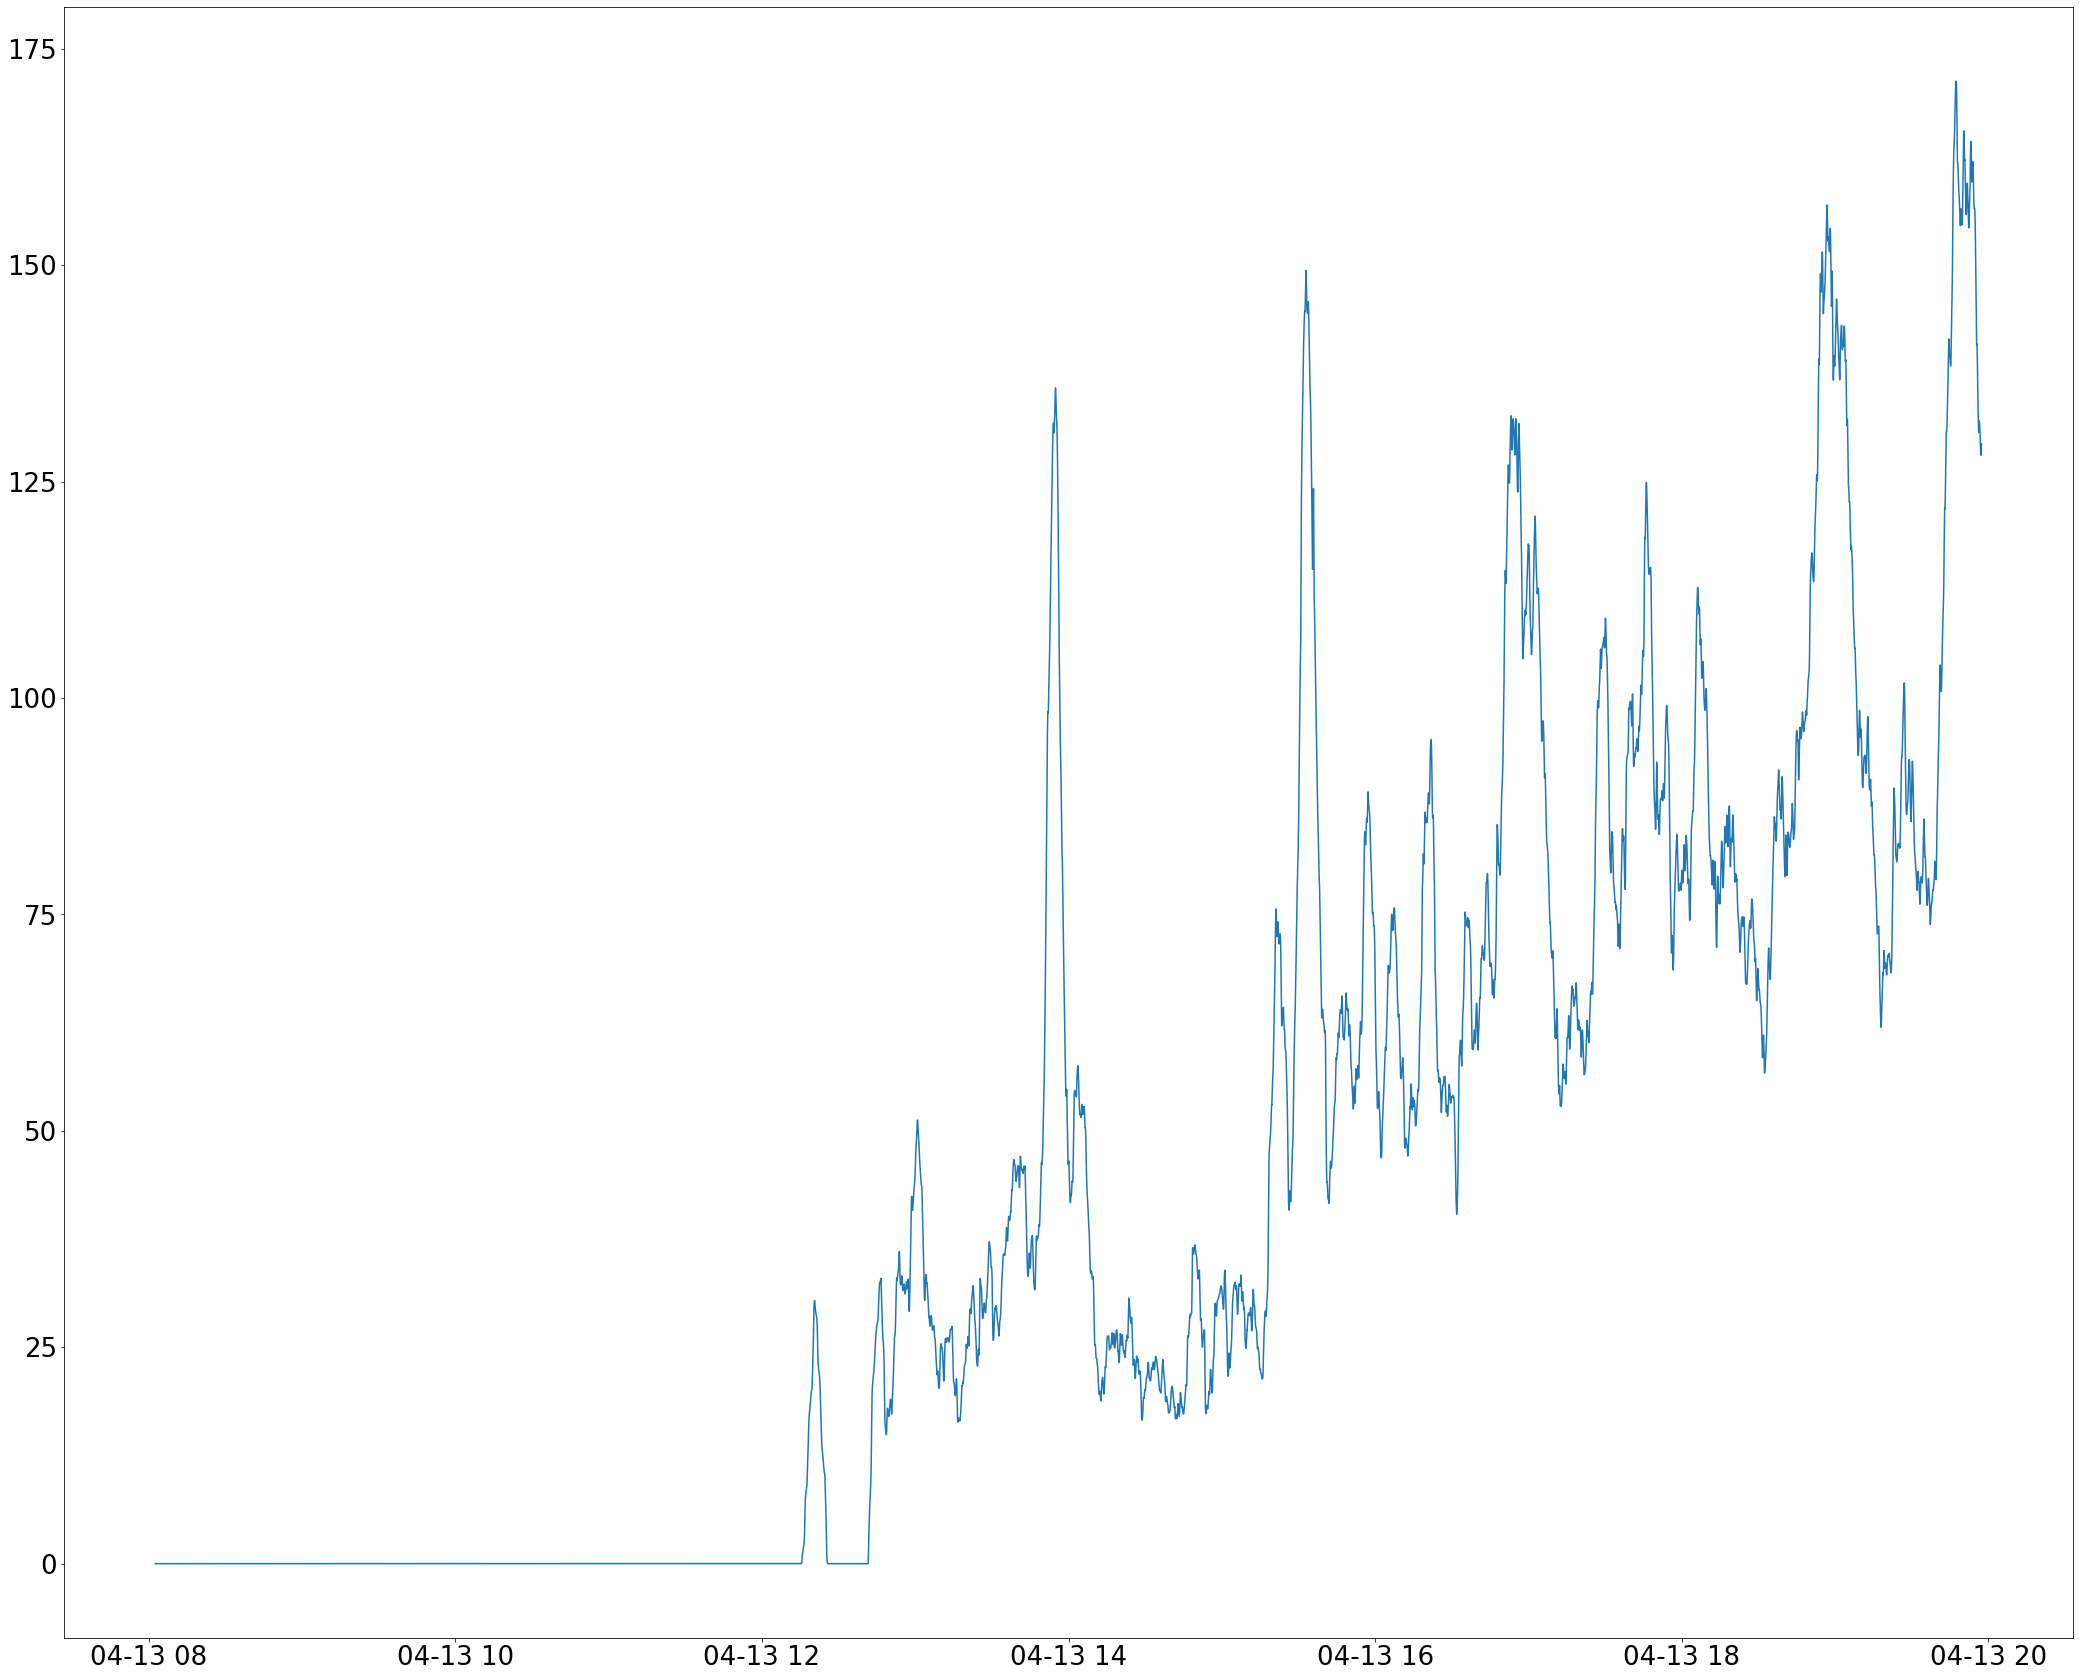

In [130]:
fig1 = plt.figure(figsize=(36,30))
data_frame = mergedDataDp03['4-13-22'].set_index("Date_Time").rolling(60*5, center = True).mean().dropna()
decay_frame = decayFrame['4-13-22']['A16'][decayFrame['4-13-22']['A16'] > 10]
for index, slope in decay_frame.items():
    x = np.linspace(1,-1,301)
    y = slope*x + data_frame['A16'].loc[index]
    x_indexes = pd.date_range(start = index - pd.Timedelta(seconds = 60*2.5),
                                   end   = index + pd.Timedelta(seconds = 60*2.5),
                                   freq  = '1S')
    plt.plot(x_indexes, y)
plt.plot(data_frame.index, data_frame['A16'])

In [82]:
decayFrame['4-13-22']['A16'][decayFrame['4-13-22']['A16'] > 20]

Date_Time
2022-04-13 15:33:29    35.4
2022-04-13 15:38:09    29.1
2022-04-13 16:20:49    26.1
2022-04-13 17:47:49    22.2
2022-04-13 18:43:09    22.2
2022-04-13 18:56:29    35.4
Name: A16, dtype: float64